In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/train.csv


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *
from fastai.tabular import *
import imageio

In [4]:
path='../input/digit-reccognizer'
test = pd.read_csv('../input/digit-recognizer/test.csv')

In [5]:
train=pd.read_csv('../input/digit-recognizer/train.csv')

In [6]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
def to_img_shape(data_X, data_y=[]):
    data_X = np.array(data_X).reshape(-1,28,28)
    data_X = np.stack((data_X,)*3, axis=-1)
    data_y = np.array(data_y)
    return data_X,data_y

In [8]:
data_X, data_y = train.loc[:,'pixel0':'pixel783'], train['label']

from sklearn.model_selection import train_test_split

train_X, val_X, train_y, val_y = train_test_split(data_X, data_y, test_size=0.1,random_state=42,stratify=data_y)

test_X = test.loc[:,'pixel0':'pixel783']

In [9]:
train_X,train_y = to_img_shape(train_X, train_y)
val_X,val_y = to_img_shape(val_X,val_y)
test_X, _ = to_img_shape(test_X)

In [10]:
def save_imgs(path:Path, data, labels):
    path.mkdir(parents=True,exist_ok=True)
    for label in np.unique(labels):
        (path/str(label)).mkdir(parents=True,exist_ok=True)
    for i in range(len(data)):
        if(len(labels)!=0):
            imageio.imsave( str( path/str(labels[i])/(str(i)+'.jpg') ), data[i] )
        else:
            imageio.imsave( str( path/(str(i)+'.jpg') ), data[i] )

save_imgs(Path('/data/train'),train_X,train_y)
save_imgs(Path('/data/valid'),val_X,val_y)
save_imgs(Path('/data/test'),test_X, [])

In [11]:
path = ("../input/digit-recognizer")

In [12]:
tfms = get_transforms(flip_vert=False, max_lighting=0.1, max_zoom=1.1, max_warp=0.)

In [13]:
np.random.seed(42)
src = (ImageList.from_folder('/data/')
       .split_by_folder()
       .label_from_folder()
       .add_test_folder()          
       .transform(tfms, size=28)   
       .databunch().normalize(imagenet_stats))


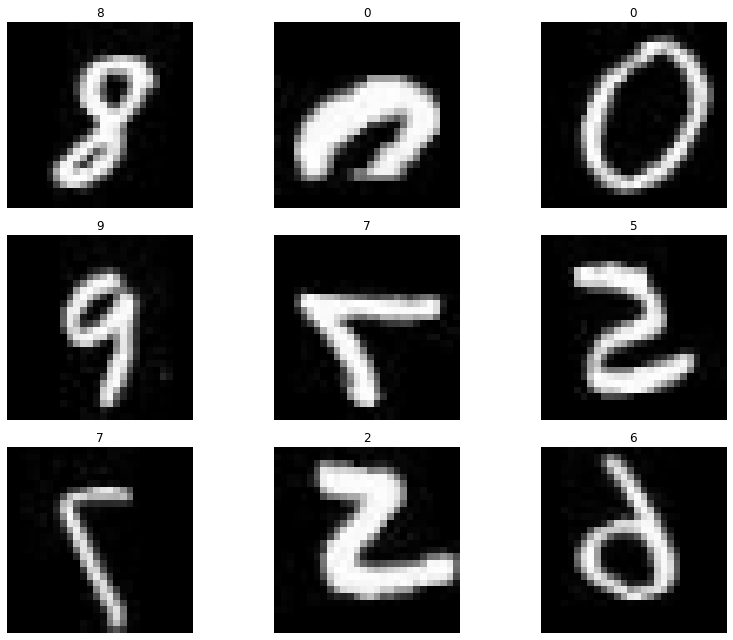

In [14]:
src.show_batch(rows=3, figsize=(12,9))


In [15]:
arch = models.resnet50


In [16]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(src, arch, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [17]:
learn.lr_find(end_lr=100)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


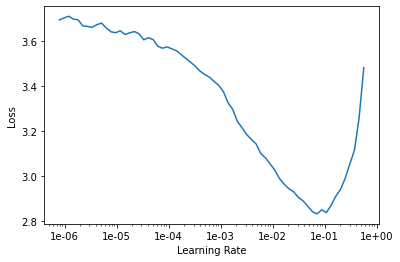

In [18]:
learn.recorder.plot()

In [19]:
lr=1e-02
learn.fit_one_cycle(5,slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.706304,0.569942,0.824524,01:08
1,0.273764,0.158371,0.948095,01:07
2,0.159771,0.095561,0.969286,01:08
3,0.110928,0.076892,0.977619,01:07
4,0.093758,0.068016,0.979762,01:08


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


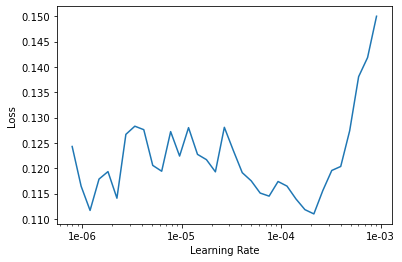

In [20]:
learn.unfreeze()
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [21]:
learn.fit_one_cycle(8,slice(1e-5,lr/5))

epoch,train_loss,valid_loss,accuracy,time
0,0.119692,0.069447,0.978571,01:14
1,0.112000,0.081579,0.976905,01:14
2,0.088979,0.064477,0.981905,01:13
3,0.061229,0.046523,0.985952,01:15
4,0.047547,0.039430,0.988095,01:14
5,0.034898,0.033497,0.990000,01:14
6,0.026426,0.032531,0.991667,01:14
7,0.025589,0.031857,0.991429,01:15


In [22]:
learn = cnn_learner(src, models.resnet50, metrics=accuracy)

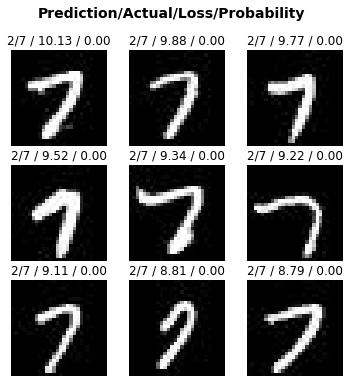

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9,figsize=(6,6))

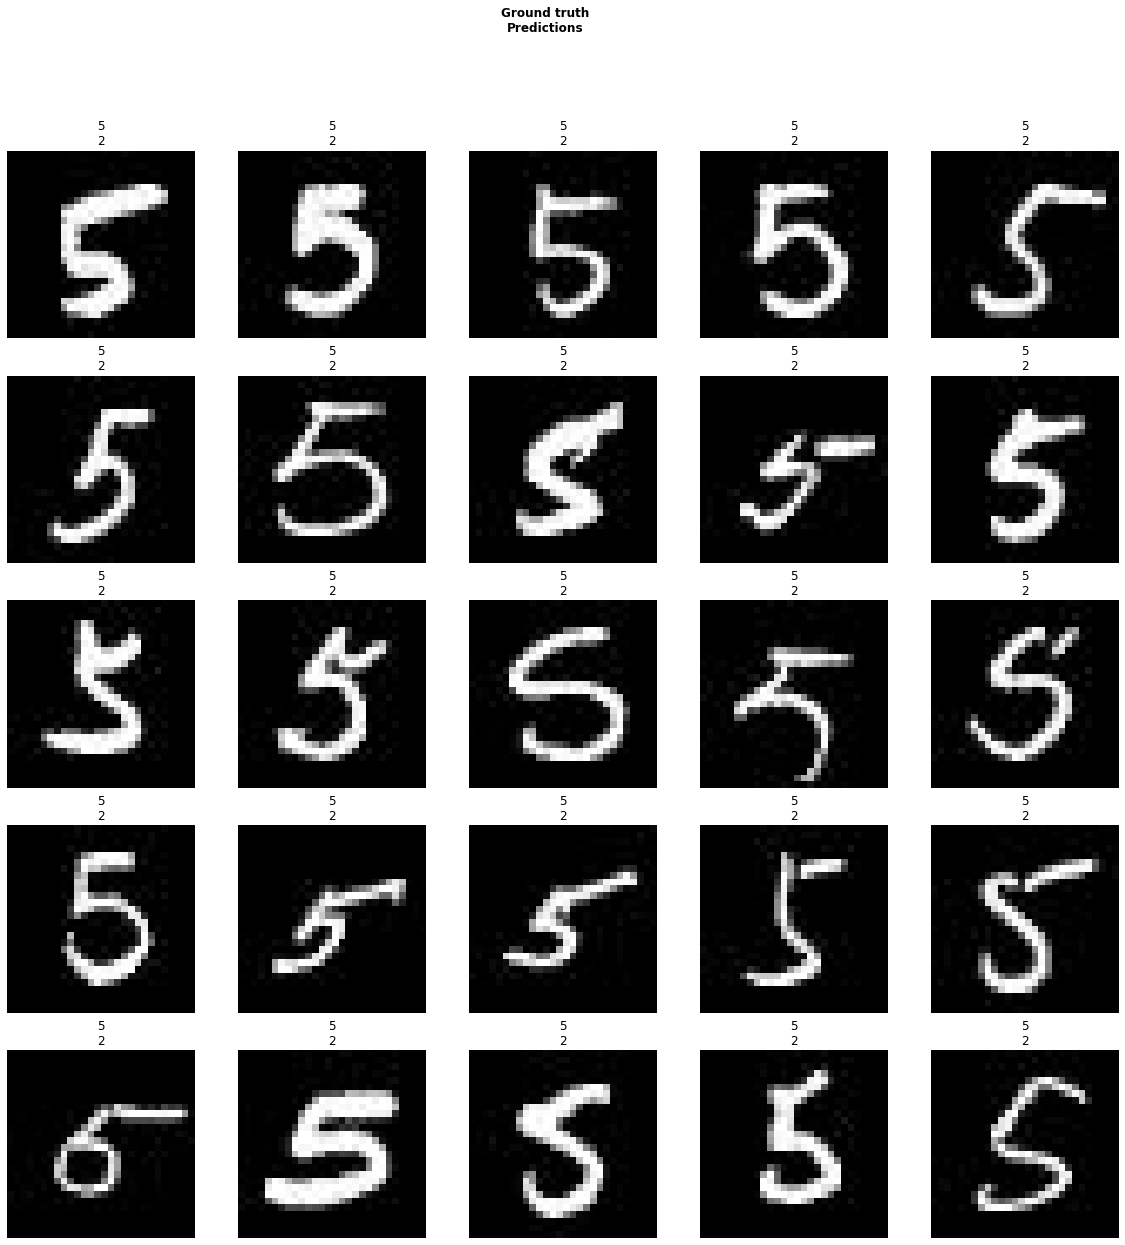

In [24]:
learn.show_results()

In [25]:
test_data = np.array(test)

In [26]:
def get_img(data):
    t1 = data.reshape(28,28)/255
    t1 = np.stack([t1]*3,axis=0)
    img = Image(FloatTensor(t1))
    return img

In [27]:
from fastprogress import progress_bar

In [28]:
sub_df = pd.DataFrame(columns=['ImageId','Label'])

In [29]:
mb=progress_bar(range(test_data.shape[0]))
for i in mb:
    timg=test_data[i]
    img = get_img(timg)
    sub_df.loc[i]=[i+1,int(learn.predict(img)[1])]

In [30]:
sub_df.head()

,ImageId,Label
0,1,2
1,2,2
2,3,2
3,4,2
4,5,2


In [31]:
sub_df.to_csv('new.csv',index=False)